# Embed and Predict (BoW)

We treat each document as a Bag of Words (BoW), and just average the GloVe word embeddings to create document vectors, and run them through a 2 layer classifier network.

In [1]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
import numpy as np
import logging
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")
WORD_EMBED_SIZE = 300

NUM_CLASSES = 20
BATCH_SIZE = 64
NUM_EPOCHS = 50

logging.basicConfig()

## Load Vocabulary

In [3]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 40730


## Load GloVe embeddings

In [4]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if not word2id.has_key(word):
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(40730, 300)


## Compute Document Vectors

In [5]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [6]:
D = np.zeros((num_docs, WORD_EMBED_SIZE))
for i, text in enumerate(ng_data.data):
    doc_vec = np.zeros(WORD_EMBED_SIZE)
    num_words = 0
    for sent in nltk.sent_tokenize(text):
        sent = sent.encode("utf8").decode("ascii", "ignore").lower()
        for word in nltk.word_tokenize(sent):
            try:
                doc_vec += E[word2id[word]]
            except KeyError:
                doc_vec += E[word2id["UNK"]]
            num_words += 1
    doc_vec /= num_words
    D[i] = doc_vec
print(D.shape)

(18846, 300)


## Data Generation

In [7]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [8]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(D, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 300) (13192, 20) (5654, 300) (5654, 20)


## Define Network

In [9]:
inputs = Input(shape=(WORD_EMBED_SIZE, ))
fc1 = Dense(100, activation="relu")(inputs)
fc1_dropout = Dropout(0.2)(fc1)
fc2 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc2)
outputs = Dense(NUM_CLASSES, activation="softmax")(fc1_dropout)

In [10]:
model = Model(inputs=inputs, outputs=outputs)

In [11]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
             metrics=["accuracy"])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2020      
Total params: 32,120
Trainable params: 32,120
Non-trainable params: 0
_________________________________________________________________


## Train Network

In [13]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, validation_split=0.1)

Train on 11872 samples, validate on 1320 samples
Epoch 1/50
11872/11872 [==============================] - 2s - loss: 2.6806 - acc: 0.2431 - val_loss: 2.2646 - val_acc: 0.4508
Epoch 2/50
11872/11872 [==============================] - 0s - loss: 1.9914 - acc: 0.4540 - val_loss: 1.7100 - val_acc: 0.5250
Epoch 3/50
11872/11872 [==============================] - 0s - loss: 1.6071 - acc: 0.5255 - val_loss: 1.4305 - val_acc: 0.5879
Epoch 4/50
11872/11872 [==============================] - 0s - loss: 1.4036 - acc: 0.5774 - val_loss: 1.2727 - val_acc: 0.6265
Epoch 5/50
11872/11872 [==============================] - 0s - loss: 1.2650 - acc: 0.6132 - val_loss: 1.1701 - val_acc: 0.6561
Epoch 6/50
11872/11872 [==============================] - 0s - loss: 1.1878 - acc: 0.6223 - val_loss: 1.0945 - val_acc: 0.6750
Epoch 7/50
11872/11872 [==============================] - 0s - loss: 1.1156 - acc: 0.6502 - val_loss: 1.0414 - val_acc: 0.6765
Epoch 8/50
11872/11872 [==============================] - 0s -

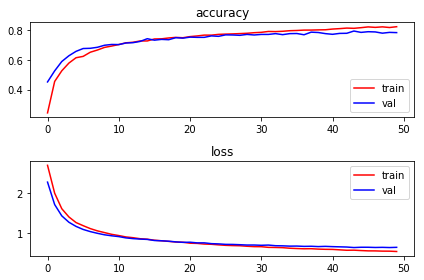

In [14]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [15]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.789

confusion matrix

[[156   1   0   0   0   1   2   2   2   1   0   1   0   6   5  30   6   3  19  14]
 [  2 178  21  14   6  44   2   0   0   1   0   2   4   5   6   0   1   2   1   1]
 [  0  21 195  33  13  37   0   0   2   2   1   1   3   0   1   0   0   0   0   0]
 [  1   6  26 205  24   5   9   0   0   0   0   2  14   0   1   0   0   0   0   0]
 [  0  13   5  47 196   6  11   1   0   0   0   0  22   0   1   0   0   0   0   0]
 [  0  27   9   4   2 255   0   0   0   0   0   2   1   0   0   0   0   0   1   0]
 [  1   4   5   9   6   1 244   6   3   0   0   0   3   2   1   0   2   0   1   0]
 [  0   1   2   0   0   2   4 271  12   0   0   0   9   1   2   0   2   1   1   0]
 [  0   2   1   0   2   0   3  12 284   0   0   0   1   1   2   0   4   0   5   0]
 [  0   0   1   0   0   0   1   0   1 280  11   1   1   2   2   2   1   0   2   1]
 [  1   0   0   0   1   0   1   0   2   5 291   1   0   0   0   0   0   0   1   0]
 [  1   1   2   0   0   7   0   0   1   0   0 